In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle
import mne
from sklearn import datasets
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score
from sklearn.pipeline import Pipeline
from mne.decoding import CSP
from Cho2017 import SubjectData
plt.rcParams['figure.figsize'] = [12, 8]
data_path = '/content/drive/MyDrive/18-797 Sem Project/Data/mat_data'
# # Make sure ipympl is installed (via pip) for interactive plots in Jupyter 
# %matplotlib widget

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [53]:
for file in os.listdir(data_path):
  file_path = os.path.join(data_path, file)
  data = SubjectData(file_path)
  with open(data_path + file + '.pkl', 'wb') as output:
    pickle.dump(data, output, pickle.HIGHEST_PROTOCOL)

In [4]:
tmin = -1
tmax = 4
reject_criteria = {'eeg': 350e-6}       # 150 µV The default from the overview tutorial
filter_freqs = (7, 30)
filter_props = dict(picks=['eeg'], fir_design='firwin', skip_by_annotation='edge')
classification_accuracies = dict()
class_balances = dict()
error_log = set()
for file in os.listdir(data_path):
  if(not '.pkl' in file):
    continue
  file_path = os.path.join(data_path, file)
  print("*******************************" + "File: " + file + "*******************************")
  with open(file_path, 'rb') as input:
    try:
      data = pickle.load(input)
      imagery_events = mne.find_events(data.raw_imagery_left, stim_channel=data.stim_channel)   # Same stim for imagery l/r
      im_left_epochs = mne.Epochs(data.raw_imagery_left, imagery_events, tmin=tmin, tmax=tmax,
                                  preload=True, reject=reject_criteria).filter(*filter_freqs, **filter_props)
      im_right_epochs = mne.Epochs(data.raw_imagery_right, imagery_events, tmin=tmin, tmax=tmax,
                                  preload=True, reject=reject_criteria).filter(*filter_freqs, **filter_props)

      movement_events = mne.find_events(data.raw_movement_left, stim_channel=data.stim_channel)  # Same stim for movement l/r
      movement_left_epochs = mne.Epochs(data.raw_movement_left, movement_events, tmin=tmin, tmax=tmax,
                                        preload=True, reject=reject_criteria).filter(*filter_freqs, **filter_props)
      movement_right_epochs = mne.Epochs(data.raw_movement_right, movement_events, tmin=tmin, tmax=tmax,
                                        preload=True, reject=reject_criteria).filter(*filter_freqs, **filter_props)
      im_left_data = im_left_epochs.copy().pick_types(eeg=True)
      im_right_data = im_right_epochs.copy().pick_types(eeg=True)
      im_left_labels = im_left_epochs.events[:, -1] - 1   # Label: 0
      im_right_labels = im_right_epochs.events[:, -1]     # Label: 1

      im_data = np.vstack((im_left_data.get_data(), im_right_data.get_data()))
      im_labels = np.hstack((im_left_labels, im_right_labels))


      print('Left Imagery Data Shape:', im_left_data.get_data().shape,
            '\t\tRight:', im_right_data.get_data().shape)
      print('Left Lables:', np.unique(im_left_labels), 'Shape:', im_left_labels.shape,
          '\t\t\t\tRight:', np.unique(im_right_labels), 'Shape:', im_right_labels.shape)
      print('Imagery Dataset Shape:', im_data.shape)
      print('Imagery Labels Shape:', im_labels.shape)

      scores = []
      # epochs_data = im_left_epochs.get_data()     # Not sure what this is for yet
      #epochs_data_train = epochs_train.get_data()  # What is this for?
      cv = ShuffleSplit(10, test_size=0.2, random_state=42)
      cv_split = cv.split(im_data)
      lda = LinearDiscriminantAnalysis()
      csp = CSP(n_components=4, reg=None, log=True, norm_trace=False)
      clf = Pipeline([('CSP', csp), ('LDA', lda)])
      scores = cross_val_score(clf, im_data, im_labels, cv=cv, n_jobs=8)

      classification_accuracies[file + '.pkl'] = np.mean(scores)

      class_balance = np.mean(im_labels == im_labels[0])
      class_balance = max(class_balance, 1. - class_balance)
      print("Classification accuracy: %f / Chance level: %f" % (np.mean(scores),
                                                            class_balance))
      class_balances[file + '.pkl'] = class_balance
      _ = csp.fit_transform(im_data, im_labels)

      csp.plot_patterns(im_left_epochs.copy().pick_types(eeg=True).info, ch_type='eeg',
                  units='Patterns (AU)', size=1.5)
      csp.plot_patterns(im_right_epochs.copy().pick_types(eeg=True).info, ch_type='eeg',
                  units='Patterns (AU)', size=1.5);
    except:
      print("Error in: " + file_path + '.pkl')
      error_log.add(file_path + '.pkl')

Output hidden; open in https://colab.research.google.com to view.

In [5]:
with open('classification_accuracies.pkl', 'rb') as output:
  pickle.la(classification_accuracies, output, pickle.HIGHEST_PROTOCOL)
with open('class_balances.pkl', 'wb') as output:
  pickle.dump(class_balances, output, pickle.HIGHEST_PROTOCOL)
with open('error_log.pkl', 'wb') as output:
  pickle.dump(error_log, output, pickle.HIGHEST_PROTOCOL)

In [49]:
import collections
with open('classification_accuracies.pkl', 'rb') as output:
  classification_accuracies = pickle.load(output)
classification_accuracies = {k[1:3]:v * 100 for k, v in classification_accuracies.items()}
ordered_classification_accuracies = collections.OrderedDict(sorted(classification_accuracies.items()))

In [50]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 15]

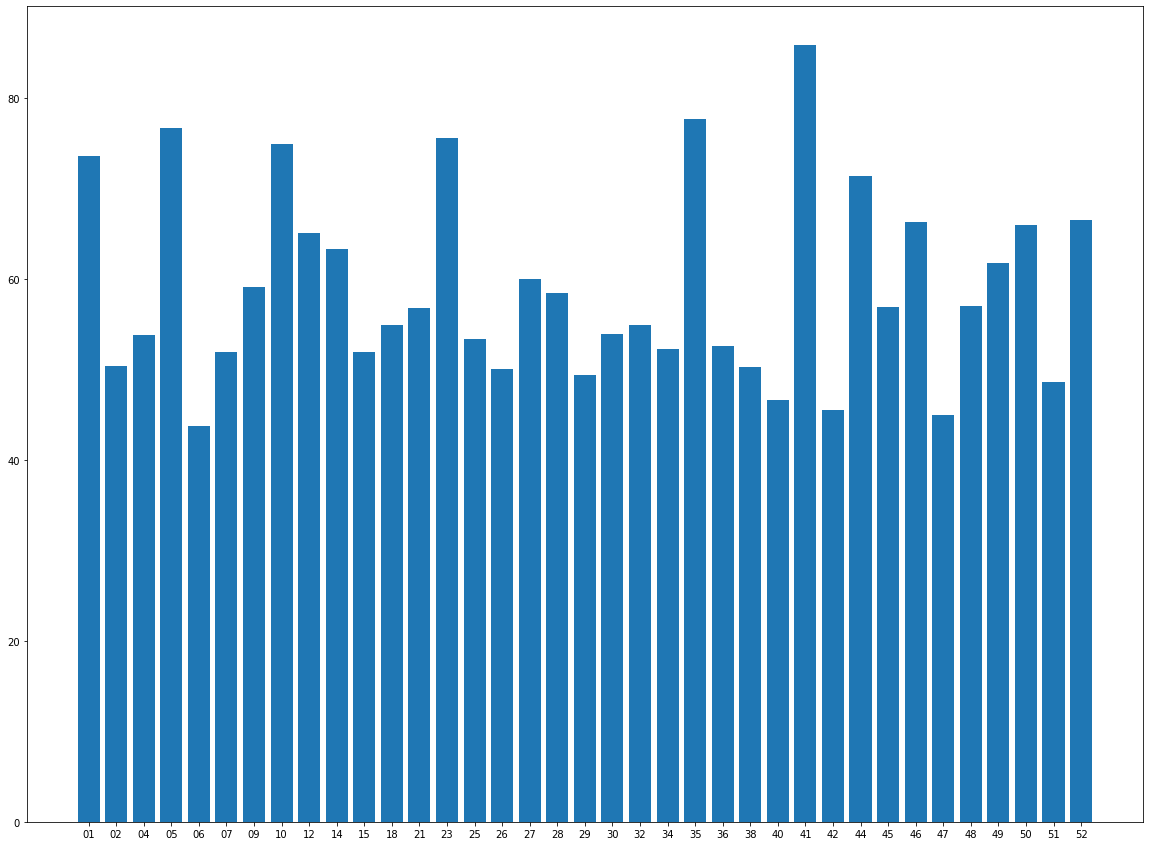

In [53]:
plt.bar(range(len(classification_accuracies)), list(ordered_classification_accuracies.values()), align='center')
plt.xticks(range(len(classification_accuracies)), list(ordered_classification_accuracies.keys()))
plt.savefig('scores.png')
plt.show()